# Lab 3

### Importing data

In [0]:
import numpy as np
import matplotlib.pyplot as plt

To get the data we used, you can download it from the google drive:


*   [data_9000.npy](https://drive.google.com/file/d/1XWcGdYUqoj-cU0MJw0KQUbFyJY06oZh1/view?usp=sharing)
*   [labels_9000.npy](https://drive.google.com/file/d/1P4zjxrIvt3rLD_T8XrMobBOrCqu-3Wog/view?usp=sharing)


It is a random combination of data collected in class and found online.  It has 1000 data points for each of the 9 letters. To see how the 9000 points were selected, look at the Jupyter Notebook: Data Wrangling.ipynb.


In [0]:
data = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/data_9000.npy')
labels = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/labels_9000.npy')

In [3]:
print(np.shape(data))
print(np.shape(labels))

(9000, 100, 100, 3)
(9000,)


## Preprocessing

### Greyscaling data

First I want to greyscale the data to remove some dimensionality and color, since color should not be a factor.

In [0]:
from skimage.color import rgb2gray

In [0]:
greyscale_data = rgb2gray(data)

In [6]:
print(np.shape(greyscale_data))

(9000, 100, 100)


### Normalizing the greyscale data

Normalizing the data so it is all on the same range of 0 to 1. Using min-max scaling.

In [0]:
for i in range(np.shape(greyscale_data)[0]):
    greyscale_data[i,:,:] = greyscale_data[i,:,:].astype("float") / 255.0

In [8]:
print(np.shape(greyscale_data))

(9000, 100, 100)


### PCA

Use PCA to try to reduce the dimensionality of the data and maximizing variance.  I will first use PCA to get the number of features required to get approximately 95% of the explained variance, and then select those features as a new training set.


In [0]:
from sklearn.decomposition import PCA

In [10]:
greyscale_data_ravel = np.empty([9000, 100*100])
for i in range(np.shape(greyscale_data)[0]):
    greyscale_data_ravel[i,:] = np.ravel(greyscale_data[i,:,:])
print(np.shape(greyscale_data_ravel))

(9000, 10000)


We only use 350 components initially because if we found all of them it would take a very long time and 350 explains almost all the variance anyways.

In [11]:
pca = PCA(n_components=350)
pca.fit(greyscale_data_ravel)

PCA(copy=True, iterated_power='auto', n_components=350, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

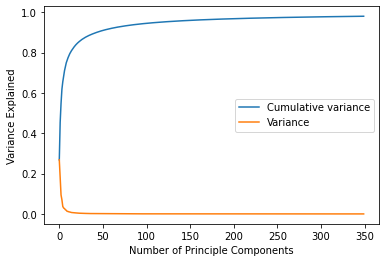

In [12]:
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Cumulative variance')
plt.plot(pca.explained_variance_ratio_, label='Variance')
plt.xlabel("Number of Principle Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.show()

In [13]:
print('Explained variance in 1st 120 components: ', pca.explained_variance_ratio_.cumsum()[120])

Explained variance in 1st 120 components:  0.951817731945796


It appear it needs about 120 features in order to maintain 95% of the data's variability.

In [0]:
pca = PCA(n_components=120)
pca.fit(greyscale_data_ravel)
greyscale_data_pca = pca.fit_transform(greyscale_data_ravel)

In [15]:
print(np.shape(greyscale_data_pca))

(9000, 120)


I only kept 120/10,000 features, so I reduced the dimensionality of the data set with only losing 5% of the variablility.

I save the grescale PCA data so that later I can use it without rerunning all of my code again.

In [0]:
#np.save('greyscale_pca_data_9000.npy', greyscale_data_pca)

#### For some of the models, greyscaling actually hurt performance, below is PCA done using the 3 color channels

Flatten and normalize orginal data

In [17]:
data_og = data.astype("float").reshape(len(data), 100*100*3) / 255.0 
print(data_og.shape)

(9000, 30000)


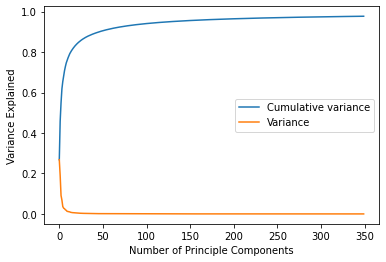

In [18]:
pca = PCA(n_components=350)
pca.fit(data_og)
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Cumulative variance')
plt.plot(pca.explained_variance_ratio_, label='Variance')
plt.xlabel("Number of Principle Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.show()

In [19]:
print('Explained variance in 1st 100 components: ', pca.explained_variance_ratio_.cumsum()[100])

Explained variance in 1st 100 components:  0.9410272675977438


With 100 components, PCA was able to retain 94% of the explained variance. 

In [0]:
pca = PCA(n_components=100)
data_og_pca = pca.fit_transform(data_og)

### Feature Extraction by LDA

Use LDA to reduce the dimensionality of my data and try to maximally seperate the classes so the models can potentially predict labels better.

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [22]:
lda = LDA()
lda.fit(greyscale_data_ravel, labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

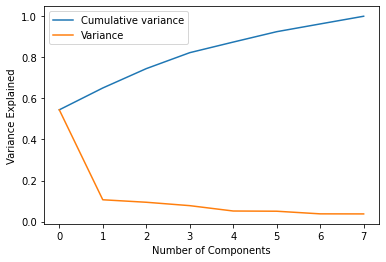

In [23]:
plt.plot(lda.explained_variance_ratio_.cumsum(), label='Cumulative variance')
plt.plot(lda.explained_variance_ratio_, label='Variance')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.show()

In [0]:
greyscale_data_lda = lda.transform(greyscale_data_ravel)

Since most of the varabililty can not be preserved if I remove some components, then I keep all of them.  As a result, I still reduce the dimensionality significantly and increase the spread of the classes from each other.

I save the grescale LDA data so that later I can use it without rerunning all of my code again.

In [0]:
#np.save('greyscale_lda_data_9000.npy', greyscale_data_lda)

## Models

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as ConfusionMatrix
import seaborn as sns

If you don't want to run the calculations for PCA and LDA, you can just import the data and uncomment the new cell's code.  You can download the data from the google drive:


*   [greyscale_pca_data_9000.npy](https://drive.google.com/file/d/19yJUuDpyj_ltWbse8EosOJ5Q0royVyw1/view?usp=sharing)
*   [greyscale_lda_data_9000.npy](https://drive.google.com/file/d/1PjmAahkWGdYtbqAjBWmySUUNQyDb6ugq/view?usp=sharing)
*   [greysale_data_ravel_900.npy](https://drive.google.com/file/d/1D5KKoBZZF4xw-dUJJ8g3GAKH0WrmiuOU/view?usp=sharing)
*   [labels_9000.npy](https://drive.google.com/file/d/1P4zjxrIvt3rLD_T8XrMobBOrCqu-3Wog/view?usp=sharing)



In [0]:
greyscale_data_pca = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/greyscale_pca_data_9000.npy')
greyscale_data_lda = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/greyscale_lda_data_9000.npy')
greyscale_data_ravel = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/greyscale_ravel_data_9000.npy')
labels = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/labels_9000.npy')

Split the data into a training and validation set so later we can evaluate the models. This testing set will be just used to validate the models' hyperparameters.  Later we will use a different data set to compare the models testing results.

In [0]:
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(greyscale_data_pca, labels, random_state=314)
Xtrain_lda, Xtest_lda, ytrain_lda, ytest_lda = train_test_split(greyscale_data_lda, labels, random_state=314)
Xtrain, Xtest, ytrain, ytest = train_test_split(greyscale_data_ravel, labels, random_state=314)
Xtrain_og, Xtest_og, ytrain_og, ytest_og = train_test_split(data_og_pca, labels, random_state=314)

* **greyscale_data_pca** is the greyscale data that is flattened and has PCA applied to it
* **greyscale_data_lda** is the greyscale data that is flattened and has LDA applied to it
* **greyscale_data_ravel** is the greyscale data that is flattened
* **data_og_pca** is the multicolor data that is flattened and has PCA applied to it

### LDA

**Finding the optimal parameters for a LDA with greyscale data.**

In [29]:
lda_model = LDA()
param_grid = {'n_components': np.arange(1, 3)}
grid_lda = GridSearchCV(lda_model, param_grid, scoring = 'accuracy')

grid_lda.fit(Xtrain, ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'n_components': array([1, 2])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [30]:
print(grid_lda.best_params_)
lda_model = grid_lda.best_estimator_

{'n_components': 1}


#### Testing LDA

Now that we have the optimal parameters for the LDA predictor, now we will now see how it performs.

In [0]:
lda_model_pred = lda_model.predict(Xtest)

Validation Accuracy:  0.6186666666666667


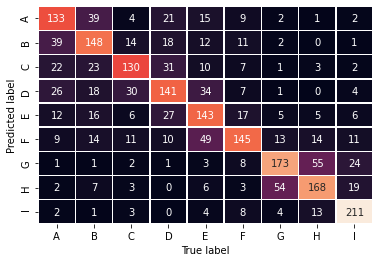

In [32]:
print('Validation Accuracy: ', accuracy_score(ytest, lda_model_pred))
cn_dt_lda = ConfusionMatrix(ytest, lda_model_pred)
sns.heatmap(cn_dt_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

**Since LDA is its own feature space manipulator we use the base grayscale data set. As can be seen, LDA does not perform well as expected since it works in linear boundaries.**

### K-Nearest Neighbor

**Finding the optimal parameters for a KNN model with LDA and PCA data.**

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 5),
             'weights': ['uniform', 'distance'],
             'p': [1, 2]}
grid_knn_pca = GridSearchCV(knn, param_grid, scoring = 'accuracy')

grid_knn_pca.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4]), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [35]:
print(grid_knn_pca.best_params_)
knn_pca = grid_knn_pca.best_estimator_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [36]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 5),
             'weights': ['uniform', 'distance'],
             'p': [1, 2]}
grid_knn_lda = GridSearchCV(knn, param_grid, scoring = 'accuracy')

grid_knn_lda.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4]), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [37]:
print(grid_knn_lda.best_params_)
knn_lda = grid_knn_lda.best_estimator_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


#### Testing KNN

Now that we have the optimal parameters for the LDA and PCA KNN, now we will now see how they compare.

In [0]:
knn_pca_pred = knn_pca.predict(Xtest_pca)

Validation Accuracy:  0.96


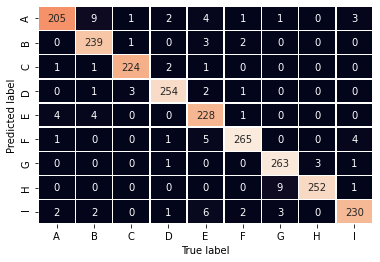

In [39]:
print('Validation Accuracy: ', accuracy_score(ytest_pca, knn_pca_pred))
cn_dt_pca = ConfusionMatrix(ytest_pca,knn_pca_pred)
sns.heatmap(cn_dt_pca, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [0]:
knn_lda_pred = knn_lda.predict(Xtest_pca)

Validation Accuracy:  0.96


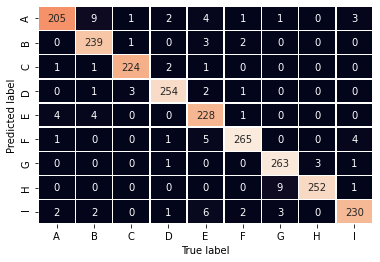

In [41]:
print('Validation Accuracy: ', accuracy_score(ytest_lda, knn_lda_pred))
cn_dt_lda = ConfusionMatrix(ytest_lda, knn_lda_pred)
sns.heatmap(cn_dt_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

**It appears that the KNN model using the LDA data performs better than the the KNN model using PCA data. This being the case, there does not seem to be any drawbacks from using**

### Decision Tree

**Finding the optimal parameters for a Decision Tree with LDA and PCA data.**

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
grid_dt_pca = GridSearchCV(DecisionTreeClassifier(random_state=314), n_jobs=-1,
                      param_grid={'criterion': ['gini', 'entropy'],
                                  'max_depth': ['None',15,20,25],
                                  'min_samples_leaf': [1,2,3]})

In [44]:
grid_dt_pca.fit(greyscale_data_pca, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=314,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [45]:
print(grid_dt_pca.best_params_)
dt_pca = grid_dt_pca.best_estimator_

{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1}


In [0]:
grid_dt_lda = GridSearchCV(DecisionTreeClassifier(random_state=314), n_jobs=-1,
                      param_grid={'criterion': ['gini', 'entropy'],
                                  'max_depth': ['None',4,5,6],
                                  'min_samples_leaf': [1,2,3]})

In [47]:
grid_dt_lda.fit(greyscale_data_lda, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=314,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [48]:
print(grid_dt_lda.best_params_)
dt_lda = grid_dt_lda.best_estimator_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}


#### Testing Decision Trees

Now that I have the optimal parameters for the LDA and PCA decision trees, now I will now see how they compare.

In [0]:
dt_pca_pred = dt_pca.predict(Xtest_pca)

Validation Accuracy:  1.0


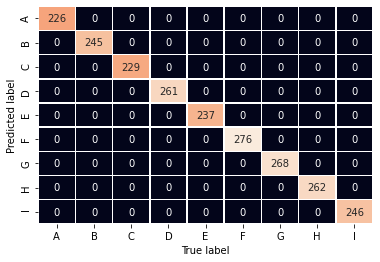

In [50]:
print('Validation Accuracy: ', accuracy_score(ytest_pca, dt_pca_pred))
cn_dt_pca = ConfusionMatrix(ytest_pca,dt_pca_pred)
sns.heatmap(cn_dt_pca, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [0]:
dt_lda_pred = dt_lda.predict(Xtest_lda)

Validation Accuracy:  1.0


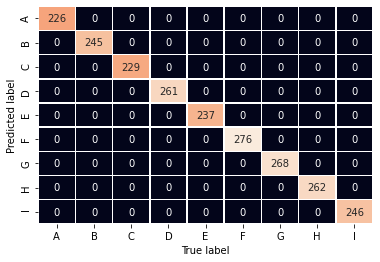

In [52]:
print('Validation Accuracy: ', accuracy_score(ytest_lda, dt_lda_pred))
cn_dt_lda = ConfusionMatrix(ytest_lda,dt_lda_pred)
sns.heatmap(cn_dt_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

**It appears that the decision tree using the LDA data performs much better than the decision tree using PCA data. However, the LDA decision tree always predicts letter 'F' wrong.  Overall, I would choose the decision tree using PCA beacause it can predict letter 'F' correctly sometimes, even though it has a lower test accuracy.**

### Random Forests

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
grid_rf_pca = GridSearchCV(RandomForestClassifier(random_state=314, n_estimators=50, bootstrap=True, oob_score=True),
                      n_jobs=-1, param_grid={'criterion': ['entropy','gini'], 
                                               'max_depth': [20,25,30],
                                               'min_samples_leaf': [1,2,3]})

In [55]:
grid_rf_pca.fit(greyscale_data_pca, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=True, random_state=314,
                                

In [56]:
print(grid_rf_pca.best_params_)
rf_pca = grid_rf_pca.best_estimator_

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1}


In [0]:
grid_rf_lda = GridSearchCV(RandomForestClassifier(random_state=314, n_estimators=50, bootstrap=True, oob_score=True),
                      n_jobs=-1, param_grid={'criterion': ['gini', 'entropy'], 
                                               'max_depth': [1,2,3],
                                               'min_samples_leaf': [1,2]})

In [58]:
grid_rf_lda.fit(greyscale_data_lda, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=True, random_state=314,
                                

In [59]:
print(grid_rf_lda.best_params_)
rf_lda = grid_rf_lda.best_estimator_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}


#### Testing Random Forests

Now that I have the optimal parameters for the LDA and PCA random forest, now I will now see how they compare.

In [0]:
rf_pca_pred = rf_pca.predict(Xtest_pca)

Validation Accuracy:  1.0


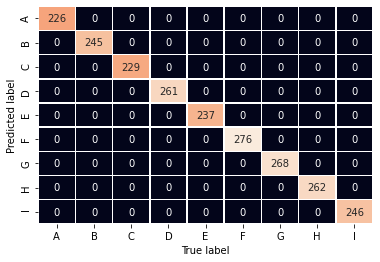

In [61]:
print('Validation Accuracy: ', accuracy_score(ytest_pca, rf_pca_pred))
cn_rf_pca = ConfusionMatrix(ytest_pca,rf_pca_pred)
sns.heatmap(cn_rf_pca, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [0]:
rf_lda_pred = rf_lda.predict(Xtest_lda)

Validation Accuracy:  1.0


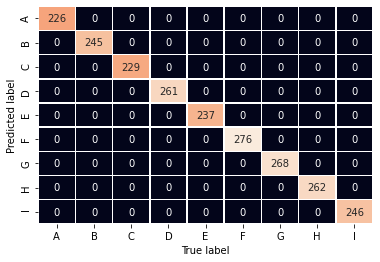

In [63]:
print('Validation Accuracy: ', accuracy_score(ytest_lda, rf_lda_pred))
cn_rf_lda = ConfusionMatrix(ytest_lda,rf_lda_pred)
sns.heatmap(cn_rf_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

**Based on the accuracies and confusion matrix, I will choose the Random Forest using LDA data beacuse it has the highest accuracy and predicts all categories well.**

### SVM

In [0]:
from sklearn.svm import SVC

In [65]:
svm = SVC(class_weight='balanced')

param_grid = {'C': [0.001, 0.01, 0.05, 0.1],
              'gamma': [0.0001, 0.0005, 0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_svm_pca = GridSearchCV(svm, param_grid, n_jobs =-1)

grid_svm_pca.fit(Xtrain_og, ytrain_og)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1],
                         'gamma': [0.0001, 0.0005, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print(grid_svm_pca.best_params_)
svm_pca = grid_svm_pca.best_estimator_

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


In [67]:
grid_svm_lda = GridSearchCV(svm, param_grid)
grid_svm_lda.fit(Xtrain_lda, ytrain_lda)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1],
                         'gamma': [0.0001, 0.0005, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
print(grid_svm_lda.best_params_)
svm_model_lda = grid_svm_lda.best_estimator_

{'C': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}


#### Testing SVM

Now that we have the optimal parameters for the LDA and PCA SVM, now we will now see how they compare.

In [0]:
svm_y_pred_pca = svm_pca.predict(Xtest_og)

Test Accuracy:  0.6813333333333333


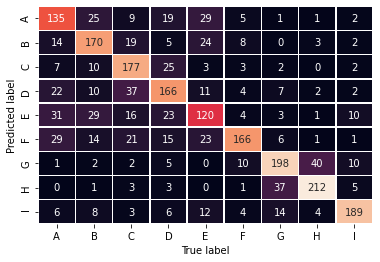

In [70]:
print('Test Accuracy: ', accuracy_score(ytest_og, svm_y_pred_pca)) 
cm_svm_pca = ConfusionMatrix(ytest_og,svm_y_pred_pca)
sns.heatmap(cm_svm_pca, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [0]:
svm_y_pred_lda = svm_model_lda.predict(Xtest_lda)

Test Accuracy:  1.0


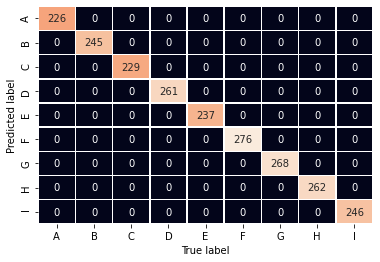

In [72]:
print('Test Accuracy: ', accuracy_score(ytest_lda, svm_y_pred_lda))
cm_svm_lda = ConfusionMatrix(ytest_lda,  svm_y_pred_lda)
sns.heatmap(cm_svm_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

### Multi-Layer Perceptron

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
mlp = MLPClassifier(activation='relu', solver='adam')
grid_mlp_pca = GridSearchCV(mlp,n_jobs=-1, 
                            param_grid={'hidden_layer_sizes': [(100,100,50),(150,100,50),(50,50),
                                                               (150,150,150),(100,100,100,50)], 
                                               'learning_rate_init': [0.001,0.01,0.05]})

In [75]:
grid_mlp_pca.fit(Xtrain_pca, ytrain_pca)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [76]:
print(grid_mlp_pca.best_params_)
mlp_pca = grid_mlp_pca.best_estimator_

{'hidden_layer_sizes': (150, 100, 50), 'learning_rate_init': 0.01}


In [0]:
mlp = MLPClassifier(activation='relu', solver='adam')
grid_mlp_lda = GridSearchCV(mlp,
                      n_jobs=-1, param_grid={'hidden_layer_sizes': [(100,100,50),(150,100,50),(50,50),
                                                                    (150,150,150),(100,100,100,50)], 
                                               'learning_rate_init': [0.001,0.01,0.05]})

In [78]:
grid_mlp_lda.fit(Xtrain_lda, ytrain_lda)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

In [79]:
print(grid_mlp_lda.best_params_)
mlp_lda = grid_mlp_lda.best_estimator_

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate_init': 0.001}


#### MLP Testing

In [0]:
mlp_pca_pred = mlp_pca.predict(Xtest_pca)

Test Accuracy:  0.9088888888888889


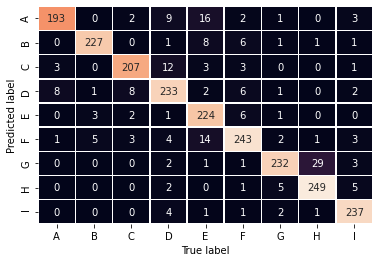

In [81]:
print('Test Accuracy: ', accuracy_score(ytest_pca, mlp_pca_pred))
cn_mlp_pca = ConfusionMatrix(ytest_pca,mlp_pca_pred)
sns.heatmap(cn_mlp_pca, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [0]:
mlp_lda_pred = mlp_lda.predict(Xtest_lda)

Test Accuracy:  1.0


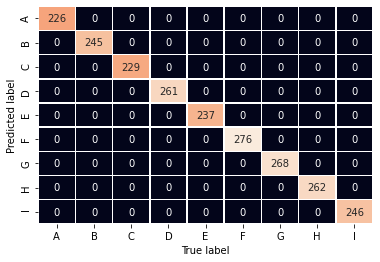

In [83]:
print('Test Accuracy: ', accuracy_score(ytest_lda, mlp_lda_pred))
cn_mlp_lda = ConfusionMatrix(ytest_lda,mlp_lda_pred)
sns.heatmap(cn_mlp_lda, cbar=False, annot=True,fmt="d", linewidths=.5,
            yticklabels=['A','B','C','D','E','F','G','H','I'],
            xticklabels=['A','B','C','D','E','F','G','H','I'])
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

Of the MLPs I would choose to use the LDA data because of the given accuracies and the confusion matrix.

## Model Comparison

**Testing data**

In [0]:
test_data = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/test_data_5000.npy')
test_labels = np.load('drive/My Drive/Colab Notebooks/EEL4930 ML Lab 3/test_labels_5000.npy')

It can be downloaded from google drive:
* [test_data]()
* [test_labels](https://drive.google.com/file/d/1EXr-EHZCFPfeqZSAWhGYQ3uygCviVZak/view?usp=sharing)

To find how it was created refer to *Data_Wrangling.ipynb*

In [0]:
def model_testing(model, test_data, test_labels):
    preds = model.predict(test_data)
    print('Test Accuracy: ', accuracy_score(test_labels, preds))
    cn = ConfusionMatrix(test_labels,preds)
    sns.heatmap(cn, cbar=False, annot=True,fmt="d", linewidths=.5,
                yticklabels=['A','B','C','D','E','F','G','H','I'],
                xticklabels=['A','B','C','D','E','F','G','H','I'])
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

Transform the data the same way as with the training data:


PCA

In [0]:
greyscale_test_data = rgb2gray(test_data)
for i in range(np.shape(greyscale_test_data)[0]):
    greyscale_test_data[i,:,:] = greyscale_test_data[i,:,:].astype("float") / 255.0
greyscale_test_data_ravel = np.empty([5000, 100*100])
for i in range(np.shape(greyscale_test_data)[0]):
    greyscale_test_data_ravel[i,:] = np.ravel(greyscale_test_data[i,:,:])
pca = PCA(n_components=120)
pca.fit(greyscale_test_data_ravel)
greyscale_test_data_pca = pca.fit_transform(greyscale_test_data_ravel)

test_data_og = test_data.astype("float").reshape(len(test_data), 100*100*3) / 255.0
pca = PCA(n_components=100)
test_data_og_pca = pca.fit_transform(test_data_og) 

LDA

In [0]:
lda = LDA()
lda.fit(greyscale_data_ravel, labels)
greyscale_test_data_lda = lda.transform(greyscale_test_data_ravel)

Testing models:

Test Accuracy:  0.7168


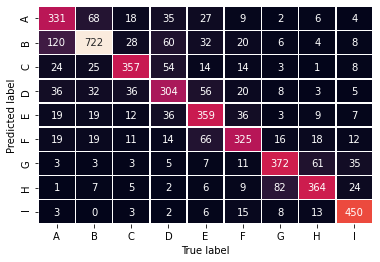

In [88]:
model_testing(lda_model, greyscale_test_data_ravel, test_labels)

Test Accuracy:  0.2408


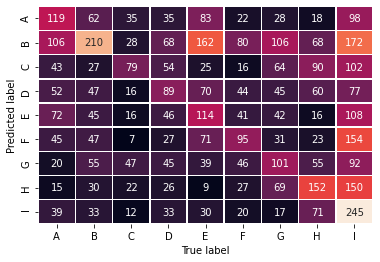

In [89]:
model_testing(knn_pca, greyscale_test_data_pca, test_labels)

Test Accuracy:  0.2408


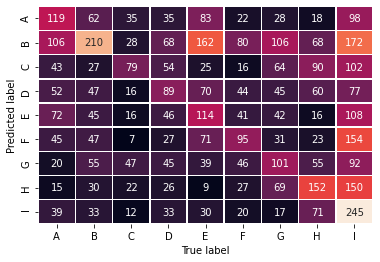

In [90]:
model_testing(knn_pca, greyscale_test_data_pca, test_labels)

Test Accuracy:  0.1198


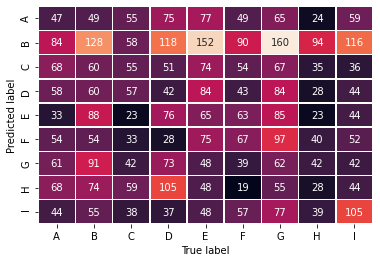

In [91]:
model_testing(dt_pca, greyscale_test_data_pca, test_labels)

Test Accuracy:  0.571


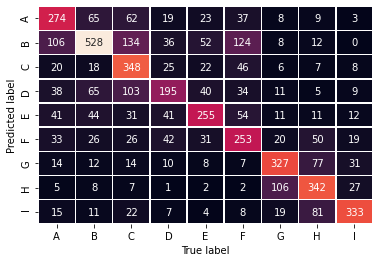

In [92]:
model_testing(dt_lda, greyscale_test_data_lda, test_labels)

Test Accuracy:  0.2136


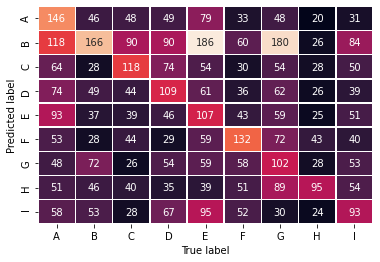

In [93]:
model_testing(rf_pca, greyscale_test_data_pca, test_labels)

Test Accuracy:  0.5684


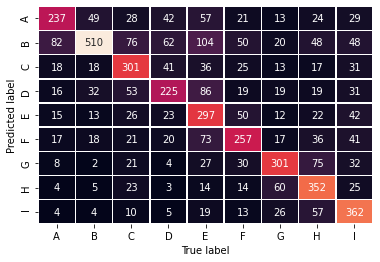

In [94]:
model_testing(rf_lda, greyscale_test_data_lda, test_labels)

Test Accuracy:  0.1974


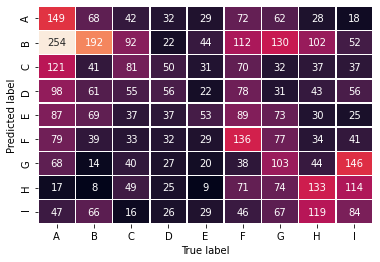

In [95]:
model_testing(svm_pca, test_data_og_pca, test_labels)

Test Accuracy:  0.6408


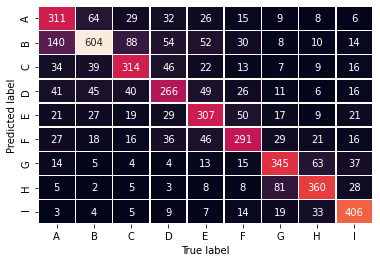

In [96]:
model_testing(svm_model_lda, greyscale_test_data_lda, test_labels)

Test Accuracy:  0.1146


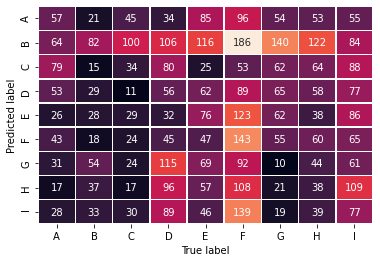

In [97]:
model_testing(mlp_pca, greyscale_test_data_pca, test_labels)

Test Accuracy:  0.6228


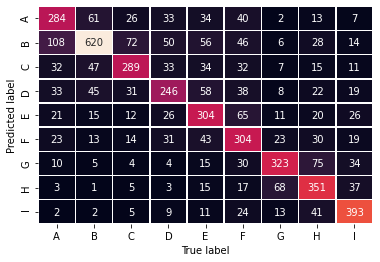

In [98]:
model_testing(mlp_lda, greyscale_test_data_lda, test_labels)